In [2]:
#!conda install -n mldds -c anaconda joblib
import os
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

import multiprocessing
num_cores = multiprocessing.cpu_count()

print("Cores: ", num_cores)

import time
import keras
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': num_cores} )
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Cores:  12


In [21]:
import pandas as pd
import numpy as np
from sklearn import utils, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.pyplot import figure
from functools import reduce
from keras.utils import to_categorical
import matplotlib.pyplot as plt


class MyTotoResearch:
    
    @classmethod
    def __init__(self, algo_no=0, inputPPFile='../input/PPv3.csv', inputTotoResult='../input/SGH.csv'):
        self.algo_number = algo_no
        print('Loaded MyTotoResearch algo_no: ', self.algo_number)

    @classmethod
    def load_totodata(self, inputPPFile='../input/PPv3.csv', inputTotoResult='../input/SGH.csv'):
        pp = pd.read_csv(inputPPFile)
        lr = pd.read_csv(inputTotoResult)
        print(len(lr))
        cols = ['D', 'N1','N2','N3','N4','N5','N6','N7']
        lr = lr[cols]

        #https://pandas.pydata.org/pandas-docs/stable/merging.html
        df = pd.concat([pp, lr], axis=1, sort=False)
        df = df.dropna()
        df.reset_index().drop(['D'], axis=1)

#         print(df.shape)
#         counts = [df['N'+str(i)].value_counts() for i in range(1,8)]
#         for i in range(len(counts)):
#             df = df[~df['N'+str(i+1)].isin(counts[i][counts[i] <= 3].index)]
#         print('After removing numbers that have shown 3 or less times')
#         print(df.shape)

        cols = ['N1','N2','N3','N4','N5','N6','N7']
        lr = df[cols]

        self.df = df
        self.lresult = np.sort(lr.values[:, ::-1])
        return self.lresult, self.df 
    
    @classmethod
    def modified_dataset ( self, dataset ):
        self.dataset = dataset
        return self.dataset
    
    @classmethod
    def get_result_n(self, col_n):
        aa = np.delete(self.lresult, np.s_[col_n:], axis=1)  
        aa = np.delete(aa, np.s_[0:col_n-1], axis=1)  
        return pd.DataFrame(aa, columns=list('N'))

    @classmethod
    def get_result_n_encoded(self, col_n):
        aa = np.delete(self.lresult, np.s_[col_n:], axis=1)  
        aa = np.delete(aa, np.s_[0:col_n-1], axis=1)  
        # 1. INSTANTIATE
        enc = preprocessing.OneHotEncoder()

        # 2. FIT
        enc.fit(aa)

        # 3. Transform
        onehotlabels = enc.transform(aa).toarray()
        onehotlabels.shape
        #print(onehotlabels)

        #Convert 2d array to Dataframe
        y = pd.DataFrame(aa, columns=list('N'))
        y.head()
        y = aa.astype(int).ravel()
    #    print ( y )
        return y
        
    @classmethod
    def get_test_data(self, file_name = '../input/PPv3-Predict.csv' ):
        self.data2Predict = pd.read_csv(file_name)
        self.data2Predict.reset_index()
        return self.data2Predict
    

    @classmethod
    def plot_history(self, history):
        loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
        val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
        acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
        val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

        if len(loss_list) == 0:
            print('Loss is missing in history')
            return 

        ## As loss always exists
        epochs = range(1,len(history.history[loss_list[0]]) + 1)

        ## Loss
        figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.figure(1)
        for l in loss_list:
            plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
        for l in val_loss_list:
            plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        ## Accuracy
        plt.figure(1)
        for l in acc_list:
            plt.plot(epochs, history.history[l], 'r', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
        for l in val_acc_list:    
            plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    @classmethod
    def save_model(self, model, predict_number):
        # serialize model to JSON
        model_json = model.to_json()
        with open(str(self.algo_number) + '_' + str(predict_number) + "_model.json", "w") as json_file:
            json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

        # serialize weights to HDF5
        model.save_weights(str(self.algo_number) + '_' + str(predict_number) + "_model.h5")
        print("Saved model to disk ", self.algo_number, " Predict #N ", predict_number)

    @classmethod
    def print_result(self, predicted_values ):
        test_df = pd.read_csv('../input/TestResult.csv', sep='\s+', header=None, names=['D','N1','N2','N3','N4','N5','N6','N7'])
        test_df['D'].replace(regex=True,inplace=True,to_replace=r'-',value=r'')
        test_df['D'] = pd.to_numeric(test_df['D'])

        cols = ['D', 'N1','N2','N3','N4','N5','N6','N7']
        test_df = self.data2Predict.merge(test_df, left_on='T', right_on='D', how='inner')
        test_df = test_df[cols]

        tdfResult = predicted_values.drop(predicted_values.columns[0], axis=1) ;

        actual_result = test_df[cols[1:]].values
        predicted_result = tdfResult.values

        matched = getIntersection(actual_result, predicted_result)

        c = 0
        for i in range(len(matched)):
            print(int(self.data2Predict.loc[i]['T']), ' ', actual_result[i], ' ', predicted_result[i], ' ', matched[c])
            c += 1
        for i in range(c, len(predicted_result)):
            print(int(self.data2Predict.loc[i]['T']), ' Predicted: ', predicted_result[i], ' ')

    @classmethod
    def load_model(self, predict_number):
        json_file = open(str(self.algo_number) + "_" + str(predict_number)+'_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)

        # load weights into new model
        loaded_model.load_weights(str(self.algo_number) + "_" + str(predict_number)+"_model.h5")
        print("Loaded model from disk " + str(self.algo_number) + "_" + str(predict_number) + "_model" )
        return loaded_model

    @classmethod
    def getTargets(self):
        return np.array([self.get_result_n(i)['N'] for i in range(1,8)]).T

    @classmethod
    def getTarget(self, N):
        return ([self.get_result_n(i)['N'] for i in range(1,8)])[N-1]


    @staticmethod
    def getIntersection(p1, p2):
        return [reduce(np.intersect1d, (p.astype(int), a.astype(int))) for (p,a) in zip(p1, p2)]

    @classmethod
    def print_predictions(self, dfPredictions, result='../input/TestResult.csv'):
        #load the test Toto Results files
        test_df = pd.read_csv(result, sep='\s+', header=None, names=['D','N1','N2','N3','N4','N5','N6','N7'])
        test_df['D'].replace(regex=True,inplace=True,to_replace=r'-',value=r'')
        test_df['D'] = pd.to_numeric(test_df['D'])

        #Merge the Planet Position File with the Toto Results file
        test_df = self.data2Predict.merge(test_df, left_on='T', right_on='D', how='inner')

        #Extract only the Results for all dates
        cols = ['D', 'N1','N2','N3','N4','N5','N6','N7']
        test_df = test_df[cols]

        tdfResult = dfPredictions.drop(dfPredictions.columns[0], axis=1) ;

        actual_result = test_df[cols[1:]].values
        predicted_result = tdfResult.values

        matched = MyTotoResearch.getIntersection(actual_result, predicted_result)

        c = 0
        for i in range(len(matched)):
            print(int(self.data2Predict.loc[i]['T']), ' ', actual_result[i], ' ', predicted_result[i], ' ', matched[c])
            c += 1
        for i in range(c, len(predicted_result)):
            print(int(self.data2Predict.loc[i]['T']), ' Predicted: ', predicted_result[i], ' ')

            
def getAdjustedDataF(df,f):
    #Use only Planet Positions Testing
    cols = ['L','M','S', 'R','E','A','V' ,'J','U','K']
    X = df[cols]
    deg = f
    
#     X['S_3'] = X['S'] // (deg*3)
#     X['L_3'] = X['L'] // (deg*3)
#     X['M_3'] = X['M'] // (deg*3)
#     X['R_3'] = X['R'] // (deg*3)
#     X['E_3'] = X['E'] // (deg*3)
#     X['A_3'] = X['A'] // (deg*3)
#     X['V_3'] = X['V'] // (deg*3)
#     X['J_3'] = X['J'] // (deg*3)
#     X['U_3'] = X['U'] // (deg*3)


#     X['S_2'] = X['S'] // (deg*2)
#     X['L_2'] = X['L'] // (deg*2)
#     X['M_2'] = X['M'] // (deg*2)
#     X['R_2'] = X['R'] // (deg*2)
#     X['E_2'] = X['E'] // (deg*2)
#     X['A_2'] = X['A'] // (deg*2)
#     X['V_2'] = X['V'] // (deg*2)
#     X['J_2'] = X['J'] // (deg*2)
#     X['U_2'] = X['U'] // (deg*2)

    X['S_1'] = X['S'] // (deg)
    X['L_1'] = X['L'] // (deg)
    X['M_1'] = X['M'] // (deg)
    X['R_1'] = X['R'] // (deg)
    X['E_1'] = X['E'] // (deg)
    X['A_1'] = X['A'] // (deg)
    X['V_1'] = X['V'] // (deg)
    X['J_1'] = X['J'] // (deg)
    X['U_1'] = X['U'] // (deg)
   
    X = X.drop(cols, axis=1)
    return X




<>:138: DeprecationWarning: invalid escape sequence \s


In [4]:
from keras.callbacks import EarlyStopping 

class MyEarlyStopping(EarlyStopping):
    def __init__(self, threshold, **kwargs):
        super(MyEarlyStopping, self).__init__(**kwargs)
        self.threshold = threshold # threshold for validation loss

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
            return

        # implement your own logic here
        if (current >= self.threshold):
            self.stopped_epoch = epoch
            self.model.stop_training = True
            
class MyEarlyStoppingLoss(EarlyStopping):
    def __init__(self, threshold, **kwargs):
        super(MyEarlyStoppingLoss, self).__init__(**kwargs)
        self.threshold = threshold # threshold for validation loss

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
            return

        # implement your own logic here
        if (current <= self.threshold):
            self.stopped_epoch = epoch
            self.model.stop_training = True

Loaded MyTotoResearch algo_no:  1
1521
(1521, 7)


/Users/walter/Software/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/walter/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


0.0
 Time taken:  0.00023600000000101318  


/Users/walter/Software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/walter/Software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/walter/Software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/walter/Software/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the

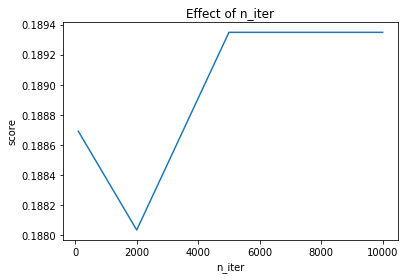

In [24]:
from keras.models import Input, Model
import keras
from keras.layers import Dense
import time
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
import json as simplejson
from keras import regularizers
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestClassifier

def getAllData(df):
    drop_cols = ['T', 'D', 'N1','N2','N3','N4','N5','N6','N7','L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X


early_stopping = MyEarlyStopping ( threshold=.99999, monitor='acc', verbose=1 )
#early_stopping_loss = MyEarlyStoppingLoss ( threshold=.005, monitor='loss', verbose=1 )

#Deep Neuro Network
mtr = MyTotoResearch(algo_no=1)
lresult, df = mtr.load_totodata()
X = mtr.modified_dataset(getAllData(df)) #
#target = np.array([mtr.get_result_n(i)['N'] for i in range(1,8)]).T
target = mtr.getTargets() ;
#print(target)
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)
                 
#sgd = SGDClassifier(max_iter=200, tol=1e-3, random_state=42, penalty="l2")
sgd = SGDClassifier(loss="log", alpha=0.001, penalty="l2", max_iter=2000, tol=1e-3, random_state=42)

multi_target_sgd = MultiOutputClassifier(sgd)
print(target.shape)
multi_target_sgd.fit(Z, mtr.getTargets()) 
print(multi_target_sgd.score(Z, mtr.getTargets()))


# multi_target_sgd = sgd
# multi_target_sgd.fit(Z, mtr.getTarget(0)) 
# print(multi_target_sgd.score(Z, mtr.getTarget(0)))

start = time.clock()
#history = multi_target_sgd.fit(X, target) #@, epochs=12000, verbose=0) #, callbacks=[early_stopping]) #, callbacks=[early_stopping]) #, checkpoint])    
print(" Time taken: ", (time.clock() - start),  " ")

n_iters = [100,2000,5000,10000]
scores = []
for n_iter in n_iters:
    model = SGDClassifier(loss="log", alpha=0.001, penalty="l2", max_iter=n_iter, tol=1e-6, random_state=42)
    model.fit(Z, mtr.getTarget(0))
    scores.append(model.score(Z, mtr.getTarget(0)))
  
plt.title("Effect of n_iter")
plt.xlabel("n_iter")
plt.ylabel("score")
plt.plot(n_iters, scores) 
plt.show()

In [25]:
def getAllData(df):
    drop_cols = ['T', 'L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X

test_data = mtr.get_test_data()
X = mtr.modified_dataset(getAllData(test_data)) #
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)
              
#X = mtr.modified_dataset(getAdjustedDataF(test_data,f))
predictions = multi_target_sgd.predict(Z)
dfResult= pd.DataFrame(predictions, columns=['N1', 'N2', 'N3', 'N4', 'N5','N6', 'N7'])
mtr.print_predictions(dfResult)




/Users/walter/Software/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/walter/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


20180514   [17 24 29 45 46 49  5]   [ 7.  9. 16. 19. 25. 45.]   [45]
20180517   [ 7 21 25 29 35 37 13]   [10. 20. 22. 30. 29. 45.]   [29]
20180521   [ 8 10 16 30 37 44 17]   [ 5.  9. 22. 30. 33. 43.]   [30]
20180524   [11 25 26 34 36 42 16]   [12.  9. 14. 23. 33. 43.]   []
20180528   [ 5  9 27 28 30 44  2]   [ 7.  9. 14. 23. 32. 43.]   [9]
20180531   [11 13 24 26 47 49 33]   [14.  9. 31. 31. 29. 45.]   []
20180604   [20 22 31 37 43 45 27]   [14. 12. 22. 24. 39. 41.]   [22]
20180607   [12 20 29 31 37 39 42]   [ 3.  9. 23. 32. 32. 45.]   []
20180611   [16 25 30 37 44 49 34]   [ 9.  9. 28. 38. 29. 38.]   []
20180614   [ 4 29 31 35 42 48  1]   [ 9.  8. 25. 32. 33. 36.]   []
20180618   [11 15 22 23 26 43 25]   [12. 13. 23. 29. 22. 43.]   [22 23 43]
20180621   [ 4  6 15 24 30 35 46]   [12.  7. 21. 38. 38. 43.]   []
20180625   [ 2  5 25 38 44 48  9]   [15.  7. 14. 31. 37. 42.]   []
20180628   [ 2  7 22 27 40 47 48]   [12. 15. 14. 27. 37. 43.]   [27]
20180702   [12 13 26 33 35 38 23]   [11. 15

In [66]:
def getAllData(df):
    drop_cols = ['T', 'D', 'N1','N2','N3','N4','N5','N6','N7','L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X

print(getAllData(df).shape)

(1521, 40)


In [ ]:
20180514   [17 24 29 45 46 49  5]   [25.  5. 35. 19. 45. 28.]   [ 5 45]
20180517   [ 7 21 25 29 35 37 13]   [22.  5. 26. 17. 22. 30.]   []
20180521   [ 8 10 16 30 37 44 17]   [25.  5. 10. 19. 20. 30.]   [10 30]
20180524   [11 25 26 34 36 42 16]   [22.  5. 10. 12. 45. 30.]   []
20180528   [ 5  9 27 28 30 44  2]   [22.  5. 35. 41. 22. 28.]   [ 5 28]
20180531   [11 13 24 26 47 49 33]   [22. 35. 35. 17. 22. 30.]   []
20180604   [20 22 31 37 43 45 27]   [22. 31. 35. 20. 22. 26.]   [20 22 31]
20180607   [12 20 29 31 37 39 42]   [24. 31. 35. 20. 16. 30.]   [20 31]
20180611   [16 25 30 37 44 49 34]   [24. 36. 10. 12. 16. 30.]   [16 30]
20180614   [ 4 29 31 35 42 48  1]   [22.  5. 10. 44. 22. 28.]   []
20180618   [11 15 22 23 26 43 25]   [22. 36. 36. 17. 22. 27.]   [22]
20180621   [ 4  6 15 24 30 35 46]   [22.  7. 37. 15. 19. 34.]   [15]
20180625   [ 2  5 25 38 44 48  9]   [22.  7. 37. 43. 48. 30.]   [48]
20180628   [ 2  7 22 27 40 47 48]   [22. 32. 37. 15. 19. 29.]   [22]
20180702   [12 13 26 33 35 38 23]   [22. 33. 35. 41. 19. 28.]   [33 35]
20180705   [ 8 11 28 30 32 34 39]   [24. 33. 35. 15. 16. 30.]   [30]
20180709   [ 6 23 31 38 39 43 33]   [23. 28. 35. 16. 20. 30.]   [23]
20180712   [ 4 15 25 32 40 41 10]   [22.  5. 35. 43. 45. 28.]   []
20180716   [ 4  8 19 24 32 47 22]   [22. 30. 35. 16. 20. 30.]   [22]
20180719   [13 14 23 35 37 46 45]   [22. 31. 35. 43. 20. 30.]   [35]
20180723   [ 2 23 26 28 39 40 12]   [22. 31. 33. 16. 20. 28.]   [28]
20180726   [ 1  9 13 17 28 40 37]   [25. 31. 12. 43. 20. 28.]   [28]
20180730   [ 8 10 19 20 41 43  7]   [25.  5.  8. 12. 21. 28.]   [8]
20180802   [ 1 10 15 27 41 46 35]   [23. 32. 35. 43. 20. 30.]   [35]
20180806   [ 7 18 20 27 36 40 15]   [25.  5. 37. 43. 20. 47.]   [20]
20180809   [13 16 20 23 39 42 28]   [23.  5. 12. 43. 48. 28.]   [23 28]
20180813   [ 1  3  6 16 22 36 17]   [25.  5. 37. 43. 46. 30.]   []
20180816   [22 23 25 32 33 36 20]   [25. 15. 10. 43. 19. 48.]   [25]
20180820   [ 9 10 25 38 40 42  2]   [25. 29. 38. 43. 48. 30.]   [25 38]
20180823   [ 2  3 23 30 39 41 19]   [22.  5. 35. 43. 48. 30.]   [30]
20180827   [ 5  6 16 24 26 29 38]   [22.  5. 35. 43. 48. 30.]   [5]
20180830   [ 3  9 27 29 31 40 46]   [23.  5. 12. 43. 20. 28.]   []
20180903   [ 4  5 13 18 39 40  3]   [22.  5. 12. 43. 48. 30.]   [5]
20180906   [ 2 15 17 20 23 30 45]   [23. 31. 36. 43. 48. 28.]   [23]
20180910   [ 2  6  9 15 40 43 18]   [22.  5. 37. 43. 48. 28.]   [43]
20180913   [ 6 16 17 40 44 48 34]   [23.  5. 37. 43. 48. 28.]   [48]
20180917   [16 21 22 24 25 27  1]   [22.  5. 12. 43. 48. 28.]   [22]
20180920   [ 5 12 18 30 32 38 22]   [23.  5. 37. 43. 46. 28.]   [5]
20180924   [ 6  8 17 24 29 47 34]   [22.  5. 37. 43. 48. 28.]   []
20180927   [ 2 25 29 33 42 45 20]   [22.  5. 37. 43. 48. 28.]   []
20181001   [11 15 23 24 32 40 43]   [22.  5. 37. 43. 46. 28.]   [43]
20181004   [ 5 12 23 32 37 42 43]   [23.  5. 37. 43. 20. 28.]   [ 5 23 37 43]
20181008   [17 18 23 39 43 49  2]   [23.  5. 36. 43. 48. 28.]   [23 43]
20181011   [ 1 16 18 24 29 46 35]   [ 2.  5. 36. 43. 22. 28.]   []
20181015   [ 1  4 24 32 35 48 20]   [23. 31. 12. 43. 48. 28.]   [48]
20181018   [ 5 14 17 31 46 48 47]   [23. 31. 12. 43. 48. 25.]   [31 48]
20181022   [ 5 22 24 40 43 48  2]   [23. 31. 12. 43. 48. 28.]   [43 48]
20181025   [ 7  8 13 15 35 48 30]   [28. 31. 12. 43. 48. 28.]   [48]
20181029   [ 2  6 10 20 28 31 30]   [24.  5. 37. 43. 48. 28.]   [28]
20181101   [ 6 27 28 41 44 48 15]   [24. 31. 38. 43. 46. 28.]   [28]
20181105   [ 3  8 14 28 43 49 26]   [ 2.  5. 37. 43. 46. 28.]   [28 43]
20181108   [ 8 13 16 26 28 38 46]   [23.  5. 37. 43. 48. 28.]   [28]
20181112   [ 4 12 21 34 41 47 33]   [23. 31. 12. 43. 48. 28.]   [12]
20181115  Predicted:  [23. 28. 37. 43. 48. 28.]  
20181119  Predicted:  [23.  5. 37. 44. 46. 28.]  
20181122  Predicted:  [23.  5. 37. 43. 48. 28.]  
20181126  Predicted:  [23.  5. 37. 43. 22. 28.]  
20181129  Predicted:  [21.  5. 36. 43. 22. 28.]  
20181203  Predicted:  [23. 31. 37. 43. 46. 28.]  
20181206  Predicted:  [23.  5. 37. 43. 48. 28.]  
20181210  Predicted:  [23.  5. 37. 43. 48. 28.]  
20181213  Predicted:  [23.  5. 37. 43. 48. 28.]  
20181217  Predicted:  [23.  5. 37. 43. 46. 28.]  
20181220  Predicted:  [22. 31. 37. 43. 46. 28.]  
20181224  Predicted:  [22.  5. 37. 43. 46. 28.]  
20181227  Predicted:  [22.  5. 37. 43. 48. 28.]  
20181231  Predicted:  [22.  5. 38. 43. 46. 28.]  

In [18]:
from keras.utils import np_utils

def getAllData(df):
    drop_cols = ['T', 'L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X

mtr = MyTotoResearch(algo_no=1)
lresult, df = mtr.load_totodata()

print(df.shape)
print(X.shape)
test_data = mtr.get_test_data()
X = mtr.modified_dataset(getAllData(test_data)) #
#X = mtr.modified_dataset(getAdjustedDataF(test_data,f))

predictions = model.predict(X)

dfResult = pd.DataFrame(test_data['T'])
for i in range(len(predictions)):
    s = 'N' + str(i+1)
    dfPN = pd.DataFrame({s:predictions[i].argmax(axis=-1)})
    dfResult = pd.concat([dfResult, dfPN], axis=1)

#print(dfResult)
mtr.print_predictions(dfResult)


Loaded MyTotoResearch algo_no:  1
1521
(1521, 59)
(1521, 40)
20180514   [17 24 29 45 46 49  5]   [ 1 16 21 22 24 25 27]   [24]
20180517   [ 7 21 25 29 35 37 13]   [ 6 16 17 34 40 44 48]   []
20180521   [ 8 10 16 30 37 44 17]   [ 2  6  9 15 18 40 43]   []
20180524   [11 25 26 34 36 42 16]   [ 2 15 17 20 23 30 45]   []
20180528   [ 5  9 27 28 30 44  2]   [ 3  4  5 13 18 39 40]   [5]
20180531   [11 13 24 26 47 49 33]   [ 3  9 27 29 31 40 46]   []
20180604   [20 22 31 37 43 45 27]   [ 5  6 16 24 26 29 38]   []
20180607   [12 20 29 31 37 39 42]   [ 2  3 19 23 30 39 41]   [39]
20180611   [16 25 30 37 44 49 34]   [ 2  9 10 25 38 40 42]   [25]
20180614   [ 4 29 31 35 42 48  1]   [20 22 23 25 32 33 36]   []
20180618   [11 15 22 23 26 43 25]   [ 1  3  6 16 17 22 36]   [22]
20180621   [ 4  6 15 24 30 35 46]   [13 16 20 23 28 39 42]   []
20180625   [ 2  5 25 38 44 48  9]   [ 7 15 18 20 27 36 40]   []
20180628   [ 2  7 22 27 40 47 48]   [ 1 10 15 27 35 41 46]   [27]
20180702   [12 13 26 33 35 38 23

In [ ]:
df['N1'].value_counts().plot(kind="bar")

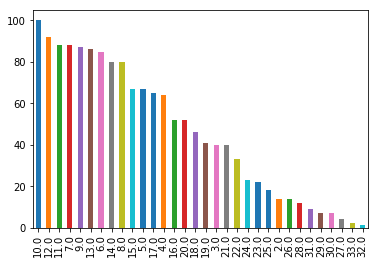

In [146]:
df['N2'].value_counts().plot(kind="bar")

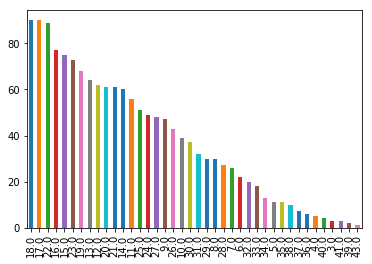

In [93]:
df['N3'].value_counts().plot(kind="bar")

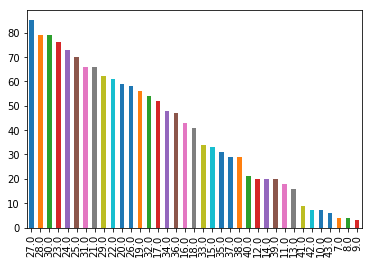

In [147]:
df['N4'].value_counts().plot(kind="bar")

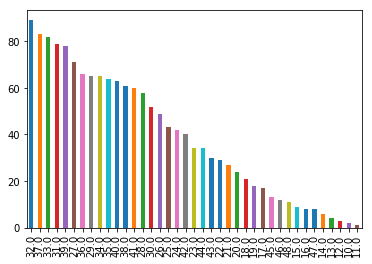

In [95]:
df['N5'].value_counts().plot(kind="bar")

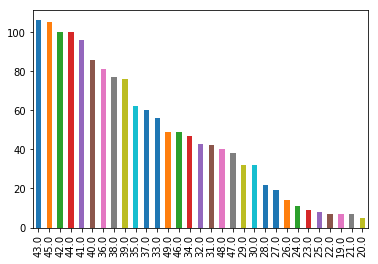

In [148]:
df['N6'].value_counts().plot(kind="bar")

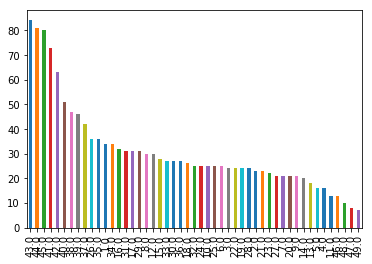

In [97]:
df['N7'].value_counts().plot(kind="bar")